In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
train = pd.read_csv('../data/train.csv', parse_dates=['date'])
test = pd.read_csv('../data/test.csv', parse_dates=['date'])
stores = pd.read_csv('../data/stores.csv')
oil = pd.read_csv('../data/oil.csv', parse_dates=['date'])
holidays = pd.read_csv('../data/holidays_events.csv', parse_dates=['date'])
transactions = pd.read_csv('../data/transactions.csv', parse_dates=['date'])

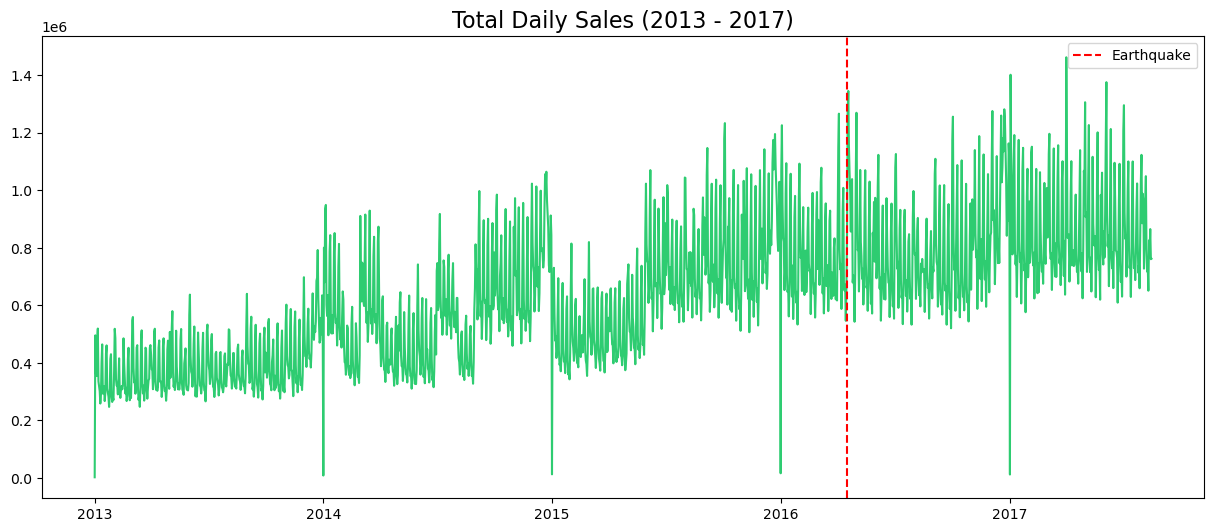

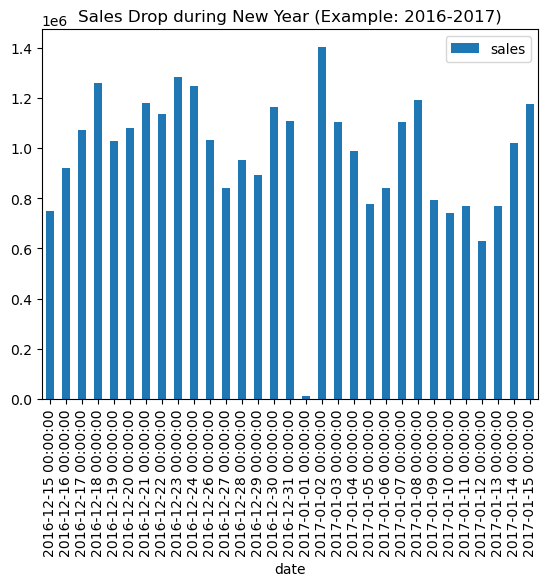

In [9]:
daily_sales = train.groupby('date').sales.sum().reset_index()

plt.figure(figsize=(15, 6))
plt.plot(daily_sales['date'], daily_sales['sales'], color='#2ecc71')
plt.title('Total Daily Sales (2013 - 2017)', fontsize=16)
plt.axvline(pd.Timestamp('2016-04-16'), color='red', linestyle='--', label='Earthquake')
plt.legend()
plt.show()

daily_sales.set_index('date').loc['2016-12-15':'2017-01-15'].plot(kind='bar')
plt.title('Sales Drop during New Year (Example: 2016-2017)')
plt.show()

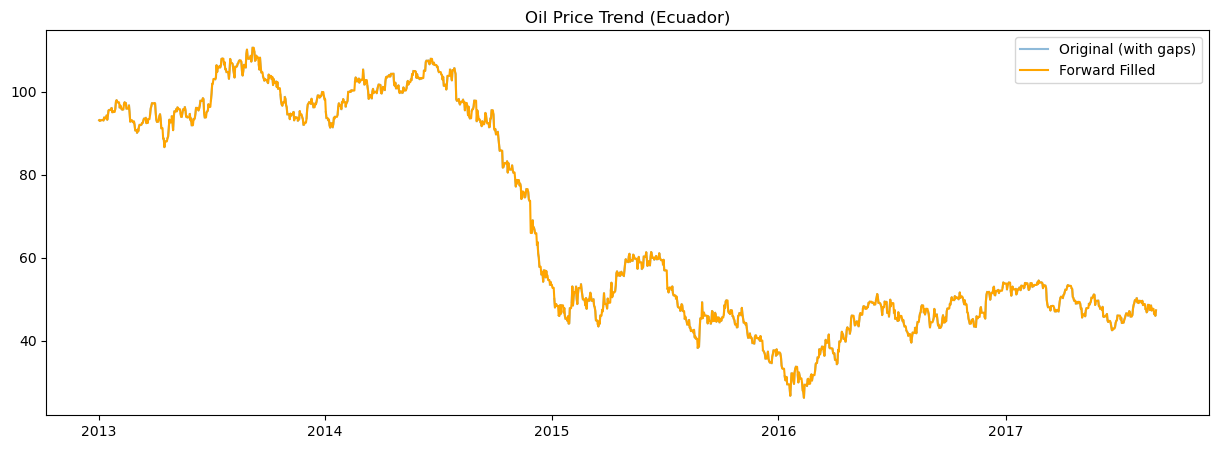

In [10]:
# 1. Create a complete date range to see where the gaps are
all_dates = pd.date_range(start=oil.date.min(), end=oil.date.max())
oil = oil.set_index('date').reindex(all_dates).reset_index().rename(columns={'index': 'date'})

# 2. Forward fill the missing values (carrying Friday price to Saturday/Sunday)
oil['dcoilwtico_ffill'] = oil['dcoilwtico'].ffill()

# 3. Plot to see the trend
plt.figure(figsize=(15, 5))
plt.plot(oil['date'], oil['dcoilwtico'], label='Original (with gaps)', alpha=0.5)
plt.plot(oil['date'], oil['dcoilwtico_ffill'], label='Forward Filled', color='orange')
plt.title('Oil Price Trend (Ecuador)')
plt.legend()
plt.show()

In [11]:
# Let's look at the "Independence of Guayaquil" example from the data description
guayaquil_example = holidays[holidays['description'].str.contains('Independencia de Guayaquil')]
print("Holiday Transfer Example:")
print(guayaquil_example[['date', 'type', 'description', 'transferred']])

# Quick check: How many holidays were actually moved?
print(f"\nTotal transferred holidays: {holidays.transferred.sum()}")

# To use this in a model, you'd want to:
# 1. Drop rows where transferred == True
# 2. Treat 'Bridge' days as additional holidays

Holiday Transfer Example:
          date      type                          description  transferred
19  2012-10-09   Holiday           Independencia de Guayaquil         True
20  2012-10-12  Transfer  Traslado Independencia de Guayaquil        False
72  2013-10-09   Holiday           Independencia de Guayaquil         True
73  2013-10-11  Transfer  Traslado Independencia de Guayaquil        False
135 2014-10-09   Holiday           Independencia de Guayaquil         True
136 2014-10-10  Transfer  Traslado Independencia de Guayaquil        False
190 2015-10-09   Holiday           Independencia de Guayaquil        False
274 2016-10-09   Holiday           Independencia de Guayaquil        False
331 2017-10-09   Holiday           Independencia de Guayaquil        False

Total transferred holidays: 12


In [12]:
def prepare_data(train_df, stores_df, oil_df, holidays_df):
    df = train_df.merge(stores_df, on='store_nbr', how='left')
    
    oil_df['dcoilwtico'] = oil_df['dcoilwtico'].ffill()
    df = df.merge(oil_df, on='date', how='left')
    
    nat_holidays = holidays_df[(holidays_df['locale'] == 'National') & 
                               (holidays_df['transferred'] == False)]
    nat_holidays = nat_holidays.drop_duplicates('date')[['date', 'type']]
    nat_holidays = nat_holidays.rename(columns={'type': 'holiday_type'})
    
    df = df.merge(nat_holidays, on='date', how='left')
    df['is_holiday'] = df['holiday_type'].notnull().astype(int)
    
    return df

df = prepare_data(train, stores, oil, holidays)

In [13]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,dcoilwtico_ffill,holiday_type,is_holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,1
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,1
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,1
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,1
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,1


In [14]:
def create_features(df):
    df['day_of_week'] = df['date'].dt.dayofweek
    df['day_of_month'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    df['is_payday'] = ((df['day_of_month'] == 15) | (df.date.dt.is_month_end)).astype(int)
    
    # Lags: What was the sale 16 days ago? 
    # (We use 16 because the test set is 15 days long)
    df['lag_16'] = df.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.shift(16))
    df['lag_30'] = df.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.shift(30))
    
    # Rolling Mean: What was the average of the 7 days ending 16 days ago?
    df['rolling_mean_7'] = df.groupby(['store_nbr', 'family'])['lag_16'].transform(lambda x: x.rolling(7).mean())
    
    return df

df = create_features(df)

In [15]:
# We'll train on everything before August 2017
# And validate on the first 15 days of August 2017
train_set = df[df['date'] < '2017-08-01'].dropna()
val_set = df[(df['date'] >= '2017-08-01') & (df['date'] <= '2017-08-15')]

# Define features and target
features = ['store_nbr', 'onpromotion', 'dcoilwtico', 'is_holiday', 
            'day_of_week', 'is_payday', 'lag_16', 'lag_30', 'rolling_mean_7']
target = 'sales'

X_train, y_train = train_set[features], train_set[target]
X_val, y_val = val_set[features], val_set[target]

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
import numpy as np

# Use a small number of trees for a quick test
model = RandomForestRegressor(n_estimators=50, max_depth=10, n_jobs=-1)
model.fit(X_train, y_train)

# Predict and Calculate RMSLE (the competition metric)
preds = model.predict(X_val)
preds = np.maximum(0, preds) # Sales cannot be negative

score = np.sqrt(mean_squared_log_error(y_val, preds))
print(f"Baseline RMSLE: {score}")

Baseline RMSLE: 0.8484989615208763


In [17]:
# 1. Prepare Test set similarly to Train set
# We need to concatenate them to calculate lags correctly for the test period
full_df = pd.concat([train, test], axis=0).reset_index(drop=True)

# 2. Re-apply the merging and feature logic
# (Using the functions we defined earlier)
full_df = prepare_data(full_df, stores, oil, holidays)
full_df = create_features(full_df)

# 3. Separate them back out
train_final = full_df[full_df['sales'].notnull()]
test_final = full_df[full_df['sales'].isnull()]

print(f"Final training rows: {len(train_final)}")
print(f"Final test rows (should be 28512): {len(test_final)}")

Final training rows: 3000888
Final test rows (should be 28512): 28512


In [18]:
# Define features (ensure this matches what you used for the baseline)
features = ['store_nbr', 'onpromotion', 'dcoilwtico', 'is_holiday', 
            'day_of_week', 'is_payday', 'lag_16', 'lag_30', 'rolling_mean_7']

# Drop NaNs created by lags in the training set
train_final = train_final.dropna(subset=features)

X_train_full = train_final[features]
y_train_full = train_final['sales']
X_test = test_final[features]

# Re-train the model on everything
print("Training final model...")
final_model = RandomForestRegressor(n_estimators=50, max_depth=10, n_jobs=-1)
final_model.fit(X_train_full, y_train_full)

# Predict for the test set
test_preds = final_model.predict(X_test)
test_preds = np.maximum(0, test_preds) # Ensure no negative sales

Training final model...


In [19]:
submission = pd.DataFrame({
    'id': test_final['id'].astype(int),
    'sales': test_preds
})

submission.to_csv('../submissions/submission.csv', index=False)
print("Submission file saved to ../submissions/submission.csv!")

Submission file saved to ../submissions/submission.csv!
